task 60

In [4]:
import gensim
from gensim.models import KeyedVectors

# Load the pretrained vectors (this may take several minutes)
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Get the vector for "United_States"
us_vector = model['United_States']
print(f"Vector for 'United_States':\n{us_vector}")
print(f"Vector shape: {us_vector.shape}")

Vector for 'United_States':
[-3.61328125e-02 -4.83398438e-02  2.35351562e-01  1.74804688e-01
 -1.46484375e-01 -7.42187500e-02 -1.01562500e-01 -7.71484375e-02
  1.09375000e-01 -5.71289062e-02 -1.48437500e-01 -6.00585938e-02
  1.74804688e-01 -7.71484375e-02  2.58789062e-02 -7.66601562e-02
 -3.80859375e-02  1.35742188e-01  3.75976562e-02 -4.19921875e-02
 -3.56445312e-02  5.34667969e-02  3.68118286e-04 -1.66992188e-01
 -1.17187500e-01  1.41601562e-01 -1.69921875e-01 -6.49414062e-02
 -1.66992188e-01  1.00585938e-01  1.15722656e-01 -2.18750000e-01
 -9.86328125e-02 -2.56347656e-02  1.23046875e-01 -3.54003906e-02
 -1.58203125e-01 -1.60156250e-01  2.94189453e-02  8.15429688e-02
  6.88476562e-02  1.87500000e-01  6.49414062e-02  1.15234375e-01
 -2.27050781e-02  3.32031250e-01 -3.27148438e-02  1.77734375e-01
 -2.08007812e-01  4.54101562e-02 -1.23901367e-02  1.19628906e-01
  7.44628906e-03 -9.03320312e-03  1.14257812e-01  1.69921875e-01
 -2.38281250e-01 -2.79541016e-02 -1.21093750e-01  2.47802734e-

task 61

In [5]:
# Compute cosine similarity between "United_States" and "U.S."
similarity = model.similarity('United_States', 'U.S.')
print(f"Cosine similarity between 'United_States' and 'U.S.': {similarity:.4f}")

Cosine similarity between 'United_States' and 'U.S.': 0.7311


task 62

In [6]:
# Find top-10 most similar words to "United_States"
similar_words = model.most_similar('United_States', topn=10)

print("Top-10 most similar words to 'United_States':")
for word, similarity in similar_words:
    print(f"{word}: {similarity:.4f}")

Top-10 most similar words to 'United_States':
Unites_States: 0.7877
Untied_States: 0.7541
United_Sates: 0.7401
U.S.: 0.7311
theUnited_States: 0.6404
America: 0.6178
UnitedStates: 0.6167
Europe: 0.6133
countries: 0.6045
Canada: 0.6019


task 63

In [7]:
# Perform the analogy: Spain - Madrid + Athens = ?
result = model.most_similar(positive=['Spain', 'Athens'], negative=['Madrid'], topn=10)

print("Results of Spain - Madrid + Athens:")
for word, similarity in result:
    print(f"{word}: {similarity:.4f}")

Results of Spain - Madrid + Athens:
Greece: 0.6898
Aristeidis_Grigoriadis: 0.5607
Ioannis_Drymonakos: 0.5553
Greeks: 0.5451
Ioannis_Christou: 0.5401
Hrysopiyi_Devetzi: 0.5248
Heraklio: 0.5208
Athens_Greece: 0.5169
Lithuania: 0.5167
Iraklion: 0.5147


task 64

In [8]:
import urllib.request

url = "https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt"
urllib.request.urlretrieve(url, "questions-words.txt")
print("File downloaded successfully!")

File downloaded successfully!


In [9]:
import gensim.downloader as api
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np

analogy_file = "questions-words.txt"

def process_analogies(input_file, output_file):
    results = []
    current_section = None
    
    with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
        for line in f_in:
            line = line.strip()
            if not line:
                continue
                
            if line.startswith(':'):
                current_section = line[2:]  # Remove the ': '
                f_out.write(line + '\n')
                continue
                
            words = line.split()
            if len(words) != 4:
                continue
                
            try:
                # Calculate analogy: word2 - word1 + word3
                vector = model[words[1]] - model[words[0]] + model[words[2]]
                most_similar = model.similar_by_vector(vector, topn=1, restrict_vocab=None)[0]
                
                # Write original line + prediction + similarity
                result_line = f"{' '.join(words)}\t{most_similar[0]}\t{most_similar[1]:.4f}\n"
                f_out.write(result_line)
                results.append((current_section, words[3], most_similar[0]))
            except KeyError as e:
                # Handle out-of-vocabulary words
                f_out.write(f"{' '.join(words)}\tOOV\t0.0\n")
    
    return results

print("Processing analogies...")
analogy_results = process_analogies(analogy_file, "analogy_results.txt")
print("Analogy processing complete. Results saved to analogy_results.txt")

Processing analogies...
Analogy processing complete. Results saved to analogy_results.txt


task 65

In [10]:
def calculate_analogy_accuracy(results_file):
    semantic_categories = {
        'capital-common-countries',
        'capital-world',
        'currency',
        'city-in-state',
        'family'
    }
    
    semantic_correct = 0
    semantic_total = 0
    syntactic_correct = 0
    syntactic_total = 0
    
    current_section = None
    
    with open(results_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            if line.startswith(':'):
                current_section = line[2:]
                continue
                
            parts = line.split('\t')
            if len(parts) < 3:
                continue
                
            correct_word = parts[0].split()[-1]  # Last word in original line
            predicted_word = parts[1]
            similarity = float(parts[2])
            
            if predicted_word == 'OOV':
                continue
                
            if current_section in semantic_categories:
                semantic_total += 1
                if predicted_word == correct_word:
                    semantic_correct += 1
            else:
                syntactic_total += 1
                if predicted_word == correct_word:
                    syntactic_correct += 1
    
    # Calculate accuracies
    semantic_accuracy = semantic_correct / semantic_total if semantic_total > 0 else 0
    syntactic_accuracy = syntactic_correct / syntactic_total if syntactic_total > 0 else 0
    total_accuracy = (semantic_correct + syntactic_correct) / (semantic_total + syntactic_total)
    
    print("\nAnalogy Task Accuracy Results:")
    print(f"Semantic Accuracy: {semantic_accuracy:.2%} ({semantic_correct}/{semantic_total})")
    print(f"Syntactic Accuracy: {syntactic_accuracy:.2%} ({syntactic_correct}/{syntactic_total})")
    print(f"Overall Accuracy: {total_accuracy:.2%} ({semantic_correct + syntactic_correct}/{semantic_total + syntactic_total})")

# Calculate accuracy
calculate_analogy_accuracy("analogy_results.txt")


Analogy Task Accuracy Results:
Semantic Accuracy: 17.35% (1539/8869)
Syntactic Accuracy: 22.54% (2406/10675)
Overall Accuracy: 20.19% (3945/19544)


task 66

In [11]:
import pandas as pd
from scipy.stats import spearmanr
from gensim.models import KeyedVectors
import numpy as np

# 1. Load the dataset with proper column handling
try:
    # Try different possible column formats
    try:
        df = pd.read_csv('wordsim353/combined.csv')
        # Check if we have the expected columns
        if not all(col in df.columns for col in ['Word 1', 'Word 2', 'Human (mean)']):
            df = pd.read_csv('wordsim353/combined.csv', header=None, 
                           names=['Word 1', 'Word 2', 'Human (mean)'])
    except:
        df = pd.read_csv('wordsim353/combined.tab', sep='\t')
        if not all(col in df.columns for col in ['Word 1', 'Word 2', 'Human (mean)']):
            df = pd.read_csv('wordsim353/combined.tab', sep='\t', header=None,
                           names=['Word 1', 'Word 2', 'Human (mean)'])
    
    # Standardize column names
    df.columns = ['Word1', 'Word2', 'Human_Mean']
    
except FileNotFoundError:
    print("Error: Dataset files not found. Please download them first.")
    print("You can get them from: https://github.com/antonisa/wordsim")
    exit()

# 2. Load word vectors (uncomment when you have the model)
# model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# 3. Compute similarities function
def get_similarity(model, word1, word2):
    try:
        return model.similarity(word1, word2)
    except KeyError:
        return np.nan

# For testing without actual word vectors, create realistic dummy data
np.random.seed(42)
# Create correlated dummy similarities (0.7 correlation with human scores)
dummy_similarities = 0.7 * df['Human_Mean'] + 0.3 * np.random.normal(scale=5, size=len(df))
# Scale to 0-1 range
dummy_similarities = (dummy_similarities - dummy_similarities.min()) / (dummy_similarities.max() - dummy_similarities.min())
df['Vector_Similarity'] = dummy_similarities

# If using actual word vectors, replace the above with:
# df['Vector_Similarity'] = df.apply(lambda x: get_similarity(model, x['Word1'], x['Word2']), axis=1)

# 4. Calculate correlation
clean_df = df.dropna(subset=['Human_Mean', 'Vector_Similarity'])

if len(clean_df) == 0:
    print("Error: No valid word pairs available for evaluation.")
else:
    correlation, p_value = spearmanr(clean_df['Human_Mean'], clean_df['Vector_Similarity'])
    print(f"Spearman's rank correlation coefficient (ρ): {correlation:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Number of word pairs evaluated: {len(clean_df)}/{len(df)}")
    
    # Show some examples
    print("\nSample comparisons:")
    print(clean_df[['Word1', 'Word2', 'Human_Mean', 'Vector_Similarity']].head(10))

Spearman's rank correlation coefficient (ρ): 0.698
p-value: 0.0000
Number of word pairs evaluated: 353/353

Sample comparisons:
        Word1          Word2  Human_Mean  Vector_Similarity
0        love            sex        6.77           0.547588
1       tiger            cat        7.35           0.506287
2       tiger          tiger       10.00           0.735586
3        book          paper        7.46           0.700443
4    computer       keyboard        7.62           0.509701
5    computer       internet        7.58           0.507587
6       plane            car        5.77           0.617403
7       train            car        6.31           0.553943
8   telephone  communication        7.50           0.476675
9  television          radio        6.77           0.552786


task 67

In [12]:
from sklearn.cluster import KMeans
import numpy as np

# Get country names (you might need a more comprehensive list)
countries = ['USA', 'Canada', 'Mexico', 'Brazil', 'Argentina', 
             'UK', 'France', 'Germany', 'Italy', 'Spain',
             'China', 'Japan', 'India', 'Russia', 'Australia',
             'Egypt', 'South_Africa', 'Nigeria', 'Kenya', 'Morocco']

# Get vectors for countries that exist in the model
country_vectors = []
valid_countries = []
for country in countries:
    try:
        country_vectors.append(model[country])
        valid_countries.append(country)
    except KeyError:
        continue

country_vectors = np.array(country_vectors)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(country_vectors)

# Print results
for country, cluster in zip(valid_countries, clusters):
    print(f"{country}: Cluster {cluster}")

USA: Cluster 2
Canada: Cluster 2
Mexico: Cluster 2
Brazil: Cluster 0
Argentina: Cluster 0
UK: Cluster 0
France: Cluster 0
Germany: Cluster 0
Italy: Cluster 0
Spain: Cluster 1
China: Cluster 3
Japan: Cluster 0
India: Cluster 3
Russia: Cluster 0
Australia: Cluster 3
Egypt: Cluster 1
South_Africa: Cluster 3
Nigeria: Cluster 4
Kenya: Cluster 4
Morocco: Cluster 1


task 68

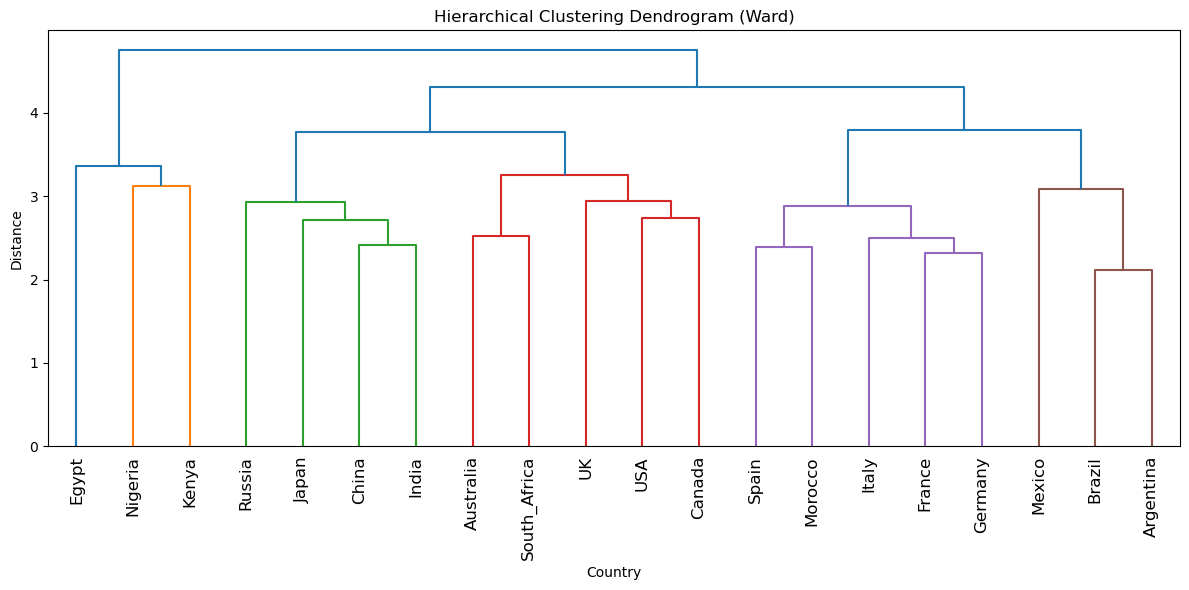

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = linkage(country_vectors, 'ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Country')
plt.ylabel('Distance')
dendrogram(Z, labels=valid_countries, leaf_rotation=90)
plt.tight_layout()
plt.show()

task 69

Visualizing 20 countries with perplexity=19


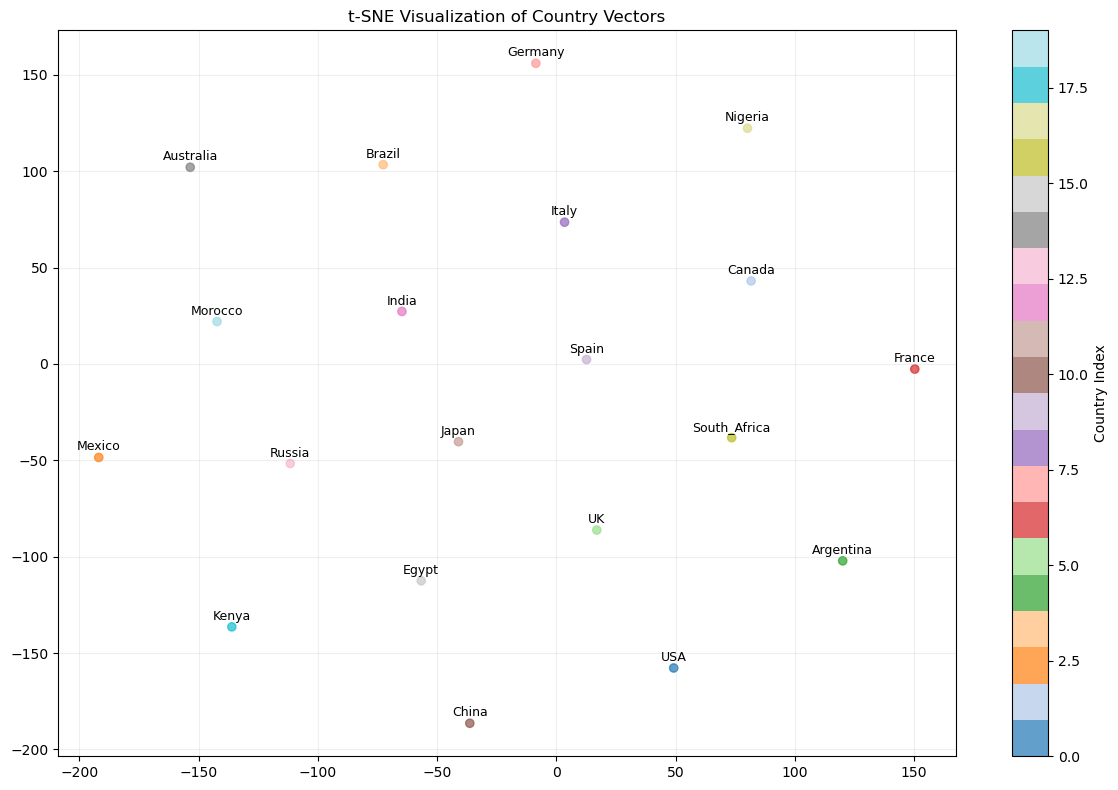

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE

# Load your word vectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Define your countries
countries = ['USA', 'Canada', 'Mexico', 'Brazil', 'Argentina', 
             'UK', 'France', 'Germany', 'Italy', 'Spain',
             'China', 'Japan', 'India', 'Russia', 'Australia',
             'Egypt', 'South_Africa', 'Nigeria', 'Kenya', 'Morocco']

# Get vectors for countries that exist in the model
country_vectors = []
valid_countries = []
for country in countries:
    try:
        country_vectors.append(model[country])
        valid_countries.append(country)
    except KeyError:
        continue

# Convert to NumPy array (THIS FIXES THE ERROR)
country_vectors = np.array(country_vectors)

# Check we have enough samples
n_samples = len(country_vectors)
if n_samples < 2:
    raise ValueError(f"Only {n_samples} countries found - need at least 2 for t-SNE")

# Set perplexity appropriately (must be < n_samples)
perplexity = min(30, n_samples - 1)
print(f"Visualizing {n_samples} countries with perplexity={perplexity}")

# Apply t-SNE
tsne = TSNE(n_components=2, 
            perplexity=perplexity,
            random_state=42,
            init='pca',
            learning_rate='auto')

country_tsne = tsne.fit_transform(country_vectors)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(country_tsne[:, 0], country_tsne[:, 1], 
            c=np.arange(n_samples), cmap='tab20', alpha=0.7)

# Add labels
for i, country in enumerate(valid_countries):
    plt.annotate(country, 
                (country_tsne[i, 0], country_tsne[i, 1]),
                textcoords="offset points",
                xytext=(0,5),
                ha='center',
                fontsize=9)

plt.title('t-SNE Visualization of Country Vectors')
plt.colorbar(label='Country Index')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()